In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [100]:
Guests= pd.read_csv('guests.csv')
Items=pd.read_csv('items.csv')
Bookings=pd.read_csv('bookings_train.csv')
itineries=pd.read_csv('itineraries.csv')
sailings=pd.read_csv('sailings.csv')
ship=pd.read_csv('ships.csv')
purchases=pd.read_csv('purchases_train.csv')

####  EDA -Finding Null Value

In [55]:
Guests.isnull().sum()

guest_id            0
guest_name          0
age                 0
age_bucket          0
gender              0
country             0
loyalty_tier    59419
party_type          0
dtype: int64

In [56]:
# Replace NaN with 'None' in bookings table
Bookings['special_occasion'] = Bookings['special_occasion'].fillna('None')

In [57]:
Guests['loyalty_tier'].fillna('None', inplace=True)

In [59]:
Guests.loyalty_tier.value_counts()

loyalty_tier
None        59419
Silver      22653
Gold        12018
Platinum     5910
Name: count, dtype: int64

In [60]:
purchases.isnull().sum()

purchase_id             0
guest_id                0
booking_id              0
sailing_id              0
item_id                 0
category                0
item_name               0
price                   0
original_price          0
purchase_timestamp      0
purchase_probability    0
dtype: int64

In [61]:
# port_of_call: replace NaN with 'None' (not tied to a port)
Items['port_of_call'] = Items['port_of_call'].fillna('None')

# available_on_ship_ids: replace NaN with empty list
Items['available_on_ship_ids'] = Items['available_on_ship_ids'].apply(lambda x: [] if pd.isna(x) else x)

# available_on_ship_types: replace NaN with ['All']
Items['available_on_ship_types'] = Items['available_on_ship_types'].apply(lambda x: ['All'] if pd.isna(x) else x)

# min_age: replace NaN with 0
Items['min_age'] = Items['min_age'].fillna(0)

# category_tags: replace NaN with empty list
Items['category_tags'] = Items['category_tags'].apply(lambda x: [] if pd.isna(x) else x)


In [62]:
## Removing Trailing values from item name

# Remove trailing #XX (e.g., "Acrobatic Dinner Show #45" → "Acrobatic Dinner Show")
purchases['item_name'] = purchases['item_name'].str.replace(r'\s#\d+$', '', regex=True)

# Verify
purchases[['item_id', 'item_name']].head()


,item_id,item_name
0,I0259,Mexican Wine Pairing
1,I0231,Asian Fusion Specialty Dinner
2,I0055,Premium Japanese Experience
3,I0431,Cultural Quarter Bus Tour Adventure
4,I0546,Scenic Bike Tour Natural Park


### EDA-Data Wrangling and Feature Selection

In [63]:
# Convert boolean to int
Items['high_margin_int'] = Items['high_margin'].astype(int)

# Select numeric columns
numeric_cols = ['price', 'high_margin_int', 'min_age']

# Compute correlation
corr_matrix = Items[numeric_cols].corr()
print(corr_matrix)


                    price  high_margin_int   min_age
price            1.000000        -0.164250  0.028302
high_margin_int -0.164250         1.000000 -0.118326
min_age          0.028302        -0.118326  1.000000


##No Correlation between High margin and price

In [64]:
## Filling the null with Possible tiers -
Guests['loyalty_tier']=Guests['loyalty_tier'].fillna('None')

### EDA- Insights for Feature selection and Engineering

### Recency and Guest Category Distribution

In [65]:
# Make sure purchase_timestamp is datetime
purchases['purchase_timestamp'] = pd.to_datetime(purchases['purchase_timestamp'])

# Get latest sailing date (or snapshot date) for reference
snapshot_date = purchases['purchase_timestamp'].max() + pd.Timedelta(days=1)

# Compute recency (days since last purchase) per guest
guest_recency = purchases.groupby('guest_id')['purchase_timestamp'].max().reset_index()
guest_recency['recency_days'] = (snapshot_date - guest_recency['purchase_timestamp']).dt.days

# Merge with guest info
guest_recency = guest_recency.merge(Guests[['guest_id','loyalty_tier','age','party_type']], on='guest_id', how='left')


In [66]:
guest_category = purchases.groupby(['guest_id','category']).size().unstack(fill_value=0).reset_index()

# Merge with recency
guest_summary = guest_recency.merge(guest_category, on='guest_id', how='left')


In [67]:
# Select only numeric columns
corr_data = guest_summary.select_dtypes(include='number')

# Correlation matrix
corr_matrix = corr_data.corr()['recency_days'].sort_values(ascending=False)
print(corr_matrix)


recency_days     1.000000
age             -0.096327
Entertainment   -0.131618
Activity        -0.153149
Excursion       -0.175776
Spa             -0.181273
Dining          -0.187956
Name: recency_days, dtype: float64


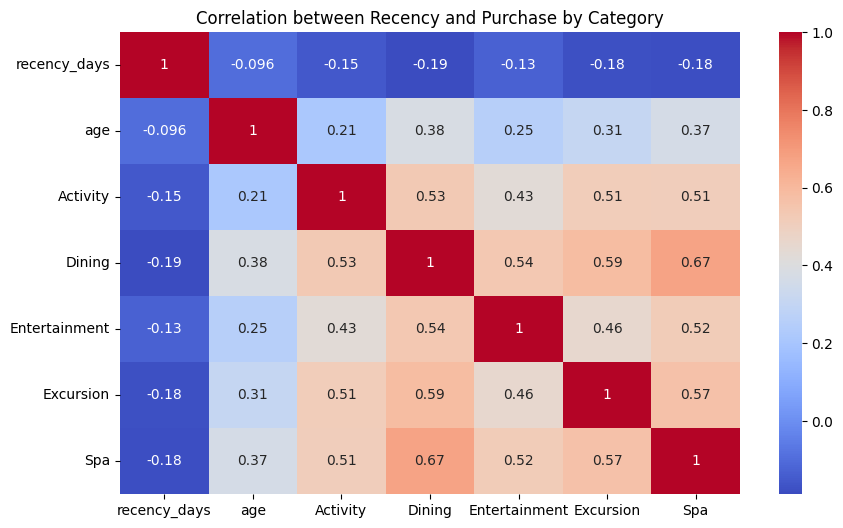

In [68]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation between Recency and Purchase by Category')
plt.show()


### Very less Correlation between recency and Purchase probability

###### Data Preperation

In [16]:
# Merge on sailing_id
purchases_sailings = purchases.merge(sailings, on='sailing_id', how='left')


In [17]:
# Merge on guest_id
purchases_sailings_guests = purchases_sailings.merge(Guests, on='guest_id', how='left')


In [18]:
# Keep only necessary columns from ships
ships_subset = ship[['ship_id', 'ship_type']]

# Merge with purchases_sailings_guests on ship_id
purchases_sailings_guests = purchases_sailings_guests.merge(
    ships_subset,
    on='ship_id',
    how='left'
)

### EDA-Spending Patterns on Loyalty Tiers

loyalty_tier
None        59419
Silver      22653
Gold        12018
Platinum     5910
Name: count, dtype: int64


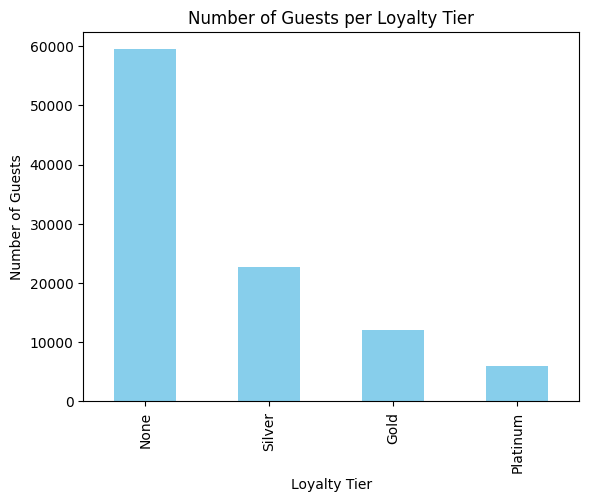

In [19]:
# Assuming Guests is your guest table
# Fill missing tiers with 'None' if needed
Guests['loyalty_tier'] = Guests['loyalty_tier'].fillna('None')

# Count number of guests per tier
tier_counts = Guests['loyalty_tier'].value_counts()

print(tier_counts)

# Optional: visualize with a bar chart
import matplotlib.pyplot as plt

tier_counts.plot(kind='bar', color='skyblue', title='Number of Guests per Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Number of Guests')
plt.show()

In [20]:
# Total spend per guest
guest_spend = purchases_sailings_guests.groupby(['guest_id','loyalty_tier'])['price'].sum().reset_index()


In [21]:
# Compute Q1, Q3 and IQR
Q1 = guest_spend['price'].quantile(0.25)
Q3 = guest_spend['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (1.5*IQR)
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Cap total spend per guest
guest_spend['spend_capped'] = guest_spend['price'].clip(lower=lower_bound, upper=upper_bound)


In [22]:
# Average capped spend per loyalty tier
tier_spend = guest_spend.groupby('loyalty_tier')['spend_capped'].agg(['count','sum','mean','median']).reset_index()
print(tier_spend)


  loyalty_tier  count           sum         mean   median
0         Gold   7102  1.905717e+07  2683.352174  2414.17
1         None  25589  5.197967e+07  2031.328555  1819.42
2     Platinum   3967  1.211902e+07  3054.957916  2814.00
3       Silver  11901  2.833168e+07  2380.613191  2110.36


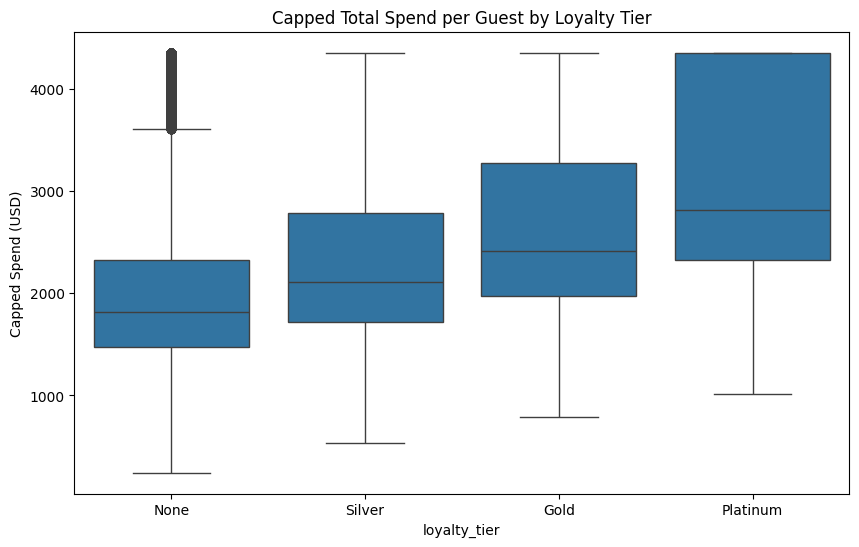

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(x='loyalty_tier', y='spend_capped', data=guest_spend, order=['None','Silver','Gold','Platinum'])
plt.title('Capped Total Spend per Guest by Loyalty Tier')
plt.ylabel('Capped Spend (USD)')
plt.show()


### EDA-Most Preffered Item for Loyalty Tiers based on Purchase probability

In [24]:
tier_item_prob = purchases_sailings_guests.groupby(
    ['loyalty_tier', 'item_id', 'item_name', 'category']
)['purchase_probability'].mean().reset_index()

# Optional: find the top N items per tier
top_items_per_tier = tier_item_prob.sort_values(
    ['loyalty_tier', 'purchase_probability'], ascending=[True, False]
).groupby('loyalty_tier').head(10)


In [25]:
top_items_per_tier

,loyalty_tier,item_id,item_name,category,purchase_probability
30,Gold,I0031,Executive Chef's Seafood,Dining,0.513039
149,Gold,I0150,Indian Wine Pairing,Dining,0.511403
219,Gold,I0220,Chef's Table Thai,Dining,0.509089
188,Gold,I0189,Executive Chef's Mexican,Dining,0.508010
157,Gold,I0158,Master Chef Greek,Dining,0.506920
39,Gold,I0040,Artisan Thai Menu,Dining,0.505201
52,Gold,I0053,Asian Fusion Wine Pairing,Dining,0.500792
99,Gold,I0100,Chef's Table Mexican,Dining,0.500545
277,Gold,I0278,Seafood Wine Pairing,Dining,0.500512
83,Gold,I0084,Master Chef Mexican,Dining,0.499480


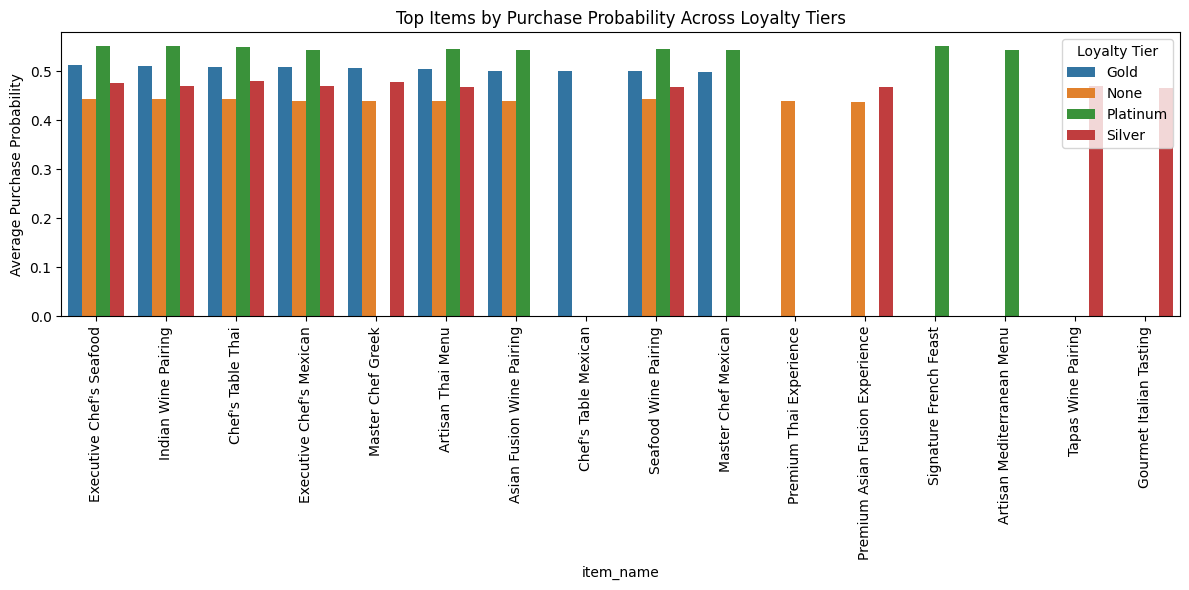

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    x='item_name', 
    y='purchase_probability', 
    hue='loyalty_tier', 
    data=top_items_per_tier
)
plt.xticks(rotation=90)
plt.ylabel('Average Purchase Probability')
plt.title('Top Items by Purchase Probability Across Loyalty Tiers')
plt.legend(title='Loyalty Tier')
plt.tight_layout()
plt.show()


#### Identifing Cold Start users 

In [69]:
# All guests
all_guests = Guests[['guest_id']]

# Guests who made purchases
guests_with_purchases = purchases_sailings_guests['guest_id'].unique()

# Cold start guests (no purchases at all)
cold_start_guests = all_guests[~all_guests['guest_id'].isin(guests_with_purchases)]

print(f"Number of cold start guests: {cold_start_guests.shape[0]}")
cold_start_guests.head()


Number of cold start guests: 51441


,guest_id
1,G000002
2,G000003
3,G000004
4,G000005
7,G000008


In [70]:

# Initialize guest_type as Cold Start for those with no purchases
all_guests['guest_type'] = all_guests['guest_id'].apply(
    lambda x: 'Cold Start' if x in cold_start_guests['guest_id'].values else 'Purchased'
)

In [71]:
# Count number of purchases per guest
guest_purchase_counts = purchases_sailings_guests.groupby('guest_id')['purchase_id'].count().reset_index()
guest_purchase_counts.rename(columns={'purchase_id': 'num_purchases'}, inplace=True)


In [72]:
# Merge with all guests
all_guests = Guests[['guest_id']].copy()
all_guests = all_guests.merge(guest_purchase_counts, on='guest_id', how='left')

# Fill NaN for guests with no purchases
all_guests['num_purchases'] = all_guests['num_purchases'].fillna(0)


In [73]:
def classify_guest(n):
    if n == 0:
        return 'Cold Start'
    elif n < 10:
        return 'Sparse History'
    else:
        return 'Rich History'

all_guests['guest_type'] = all_guests['num_purchases'].apply(classify_guest)


In [74]:
all_guests['guest_type'].value_counts()


guest_type
Cold Start        51441
Rich History      48322
Sparse History      237
Name: count, dtype: int64

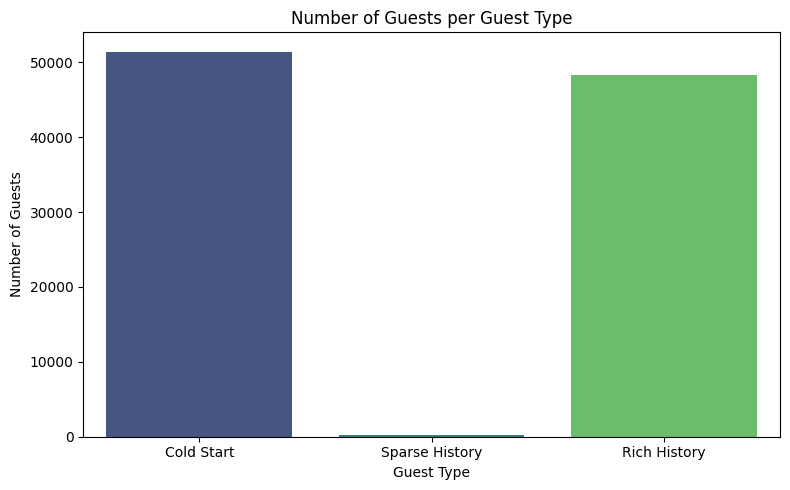

In [75]:
# Count of guests per guest_type
guest_type_counts = all_guests['guest_type'].value_counts().reset_index()
guest_type_counts.columns = ['guest_type', 'count']

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='guest_type', y='count', data=guest_type_counts, order=['Cold Start','Sparse History','Rich History'], palette='viridis')
plt.title('Number of Guests per Guest Type')
plt.ylabel('Number of Guests')
plt.xlabel('Guest Type')
plt.tight_layout()
plt.show()


### Most prefered Items by Guest Groups ( Clusetered based of Demographics, Ship type, Spending Pattern)

In [76]:
# Master data already merged: purchases_sailings_guests
purchases = purchases_sailings_guests.copy()

In [77]:
bins = [0, 30, 45, 60, 120]
labels = ['18-30','31-45','46-60','60+']
purchases['age_bucket'] = pd.cut(purchases['age'], bins=bins, labels=labels, right=False)

In [78]:
# Proportion of purchases per category
category_features = purchases.pivot_table(
    index='guest_id',
    columns='category',
    values='purchase_id',
    aggfunc='count',
    fill_value=0
)

# Normalize per guest to get proportions
category_features = category_features.div(category_features.sum(axis=1), axis=0)

# Optional: average spend per category
spend_features = purchases.pivot_table(
    index='guest_id',
    columns='category',
    values='price',
    aggfunc='mean',
    fill_value=0
)


In [79]:
demographics = purchases_sailings_guests[['guest_id', 'party_type', 'ship_type', 'age_bucket']].drop_duplicates()

# One-hot encode
demographics_encoded = pd.get_dummies(demographics.set_index('guest_id'))



In [80]:
# Set index name
category_features.index.name = 'guest_id'
spend_features.index.name = 'guest_id'
demographics_encoded.index.name = 'guest_id'

# Drop duplicates if any
category_features = category_features[~category_features.index.duplicated(keep='first')]
spend_features = spend_features[~spend_features.index.duplicated(keep='first')]
demographics_encoded = demographics_encoded[~demographics_encoded.index.duplicated(keep='first')]



In [81]:
guest_features = pd.concat([category_features, spend_features, demographics_encoded], axis=1)
guest_features.fillna(0, inplace=True)


In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(guest_features)


In [83]:
kmeans = KMeans(n_clusters=6, random_state=42)
guest_clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels
guest_cluster_df = pd.DataFrame({'guest_id': guest_features.index, 'cluster': guest_clusters})


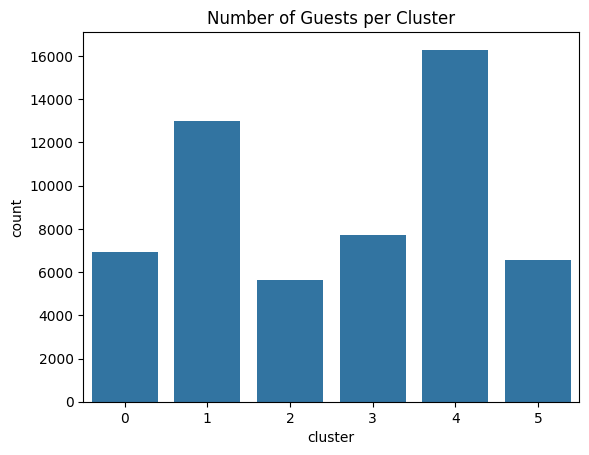

category  Activity    Dining  Entertainment  Excursion       Spa
cluster                                                         
0         0.169371  0.273969       0.102174   0.225179  0.229307
1         0.185364  0.263805       0.098946   0.215907  0.235978
2         0.165956  0.262702       0.111609   0.234211  0.225521
3         0.151026  0.277040       0.114477   0.220085  0.237372
4         0.145275  0.292016       0.111898   0.199414  0.251397
5         0.147208  0.284283       0.109914   0.199743  0.258852


In [84]:
# Merge cluster info with demographics
cluster_demo = demographics.merge(guest_cluster_df, left_on='guest_id', right_on='guest_id')

# Cluster distribution
sns.countplot(data=cluster_demo, x='cluster')
plt.title("Number of Guests per Cluster")
plt.show()

# Average category preference per cluster
category_features['cluster'] = guest_clusters
avg_category_per_cluster = category_features.groupby('cluster').mean()
print(avg_category_per_cluster)


In [85]:
popular_items = purchases_sailings_guests.merge(guest_cluster_df, on='guest_id')
popular_items_cluster = popular_items.groupby(['cluster', 'item_id','item_name']).size().reset_index(name='count')

# Top 10 items per cluster
top_items_per_cluster = popular_items_cluster.sort_values(['cluster','count'], ascending=[True,False]) \
                                              .groupby('cluster').head(2)
print(top_items_per_cluster)


      cluster item_id                        item_name  count
941         0   I0942            Orchestra Dinner Show    368
969         0   I0970                Dance Spectacular    364
1870        1   I0871        Rock Climbing Masterclass    778
1935        1   I0936                    Pilates Class    765
2940        2   I0941  Exclusive Stand-up Comedy Night    323
2948        2   I0949  Exclusive Stand-up Comedy Night    321
3941        3   I0942            Orchestra Dinner Show    490
3940        3   I0941  Exclusive Stand-up Comedy Night    453
4948        4   I0949  Exclusive Stand-up Comedy Night   1042
4984        4   I0985            Acrobatic Dinner Show   1026
5987        5   I0988  Exclusive Stand-up Comedy Night    441
5941        5   I0942            Orchestra Dinner Show    437


In [ ]:
## Master Date Merge with cluster

### Cluster Explaination
#####  0	Luxury Couples
##### 1	Family Adventure Seekers
##### 2	Solo Entertainment Travelers
##### 3	Mid-range Couples & Spa Lovers
##### 4	Young Explorer Families
##### 5	Premium Mature Travelers

In [91]:
# Create mapping
# Map cluster numbers to intuitive names
cluster_name_map = {
    0: 'Luxury Couples',
    1: 'Family Adventure Seekers',
    2: 'Solo Entertainment Travelers',
    3: 'Mid-range Couples & Spa Lovers',
    4: 'Young Explorer Families',
    5: 'Premium Mature Travelers'
}


In [93]:
top_items_per_cluster['cluster_name'] = top_items_per_cluster['cluster'].map(cluster_name_map)


In [94]:
top_items_per_cluster

,cluster,item_id,item_name,category,count,cluster_name
0,0,I0942,Orchestra Dinner Show,Entertainment,368,Luxury Couples
1,0,I0970,Dance Spectacular,Entertainment,364,Luxury Couples
2,1,I0871,Rock Climbing Masterclass,Activity,778,Family Adventure Seekers
3,1,I0936,Pilates Class,Activity,765,Family Adventure Seekers
4,2,I0941,Exclusive Stand-up Comedy Night,Entertainment,323,Solo Entertainment Travelers
5,2,I0949,Exclusive Stand-up Comedy Night,Entertainment,321,Solo Entertainment Travelers
6,3,I0942,Orchestra Dinner Show,Entertainment,490,Mid-range Couples & Spa Lovers
7,3,I0941,Exclusive Stand-up Comedy Night,Entertainment,453,Mid-range Couples & Spa Lovers
8,4,I0949,Exclusive Stand-up Comedy Night,Entertainment,1042,Young Explorer Families
9,4,I0985,Acrobatic Dinner Show,Entertainment,1026,Young Explorer Families


In [95]:
top_items_per_cluster = top_items_per_cluster[['cluster', 'cluster_name', 'item_id', 'item_name', 'category', 'count']]
top_items_per_cluster.head(10)


,cluster,cluster_name,item_id,item_name,category,count
0,0,Luxury Couples,I0942,Orchestra Dinner Show,Entertainment,368
1,0,Luxury Couples,I0970,Dance Spectacular,Entertainment,364
2,1,Family Adventure Seekers,I0871,Rock Climbing Masterclass,Activity,778
3,1,Family Adventure Seekers,I0936,Pilates Class,Activity,765
4,2,Solo Entertainment Travelers,I0941,Exclusive Stand-up Comedy Night,Entertainment,323
5,2,Solo Entertainment Travelers,I0949,Exclusive Stand-up Comedy Night,Entertainment,321
6,3,Mid-range Couples & Spa Lovers,I0942,Orchestra Dinner Show,Entertainment,490
7,3,Mid-range Couples & Spa Lovers,I0941,Exclusive Stand-up Comedy Night,Entertainment,453
8,4,Young Explorer Families,I0949,Exclusive Stand-up Comedy Night,Entertainment,1042
9,4,Young Explorer Families,I0985,Acrobatic Dinner Show,Entertainment,1026


####### PCA for feature reduction and comparison

In [219]:
from sklearn.decomposition import PCA

In [220]:
# Use PCA to reduce to 2 components for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1],
    'cluster': guest_clusters
})


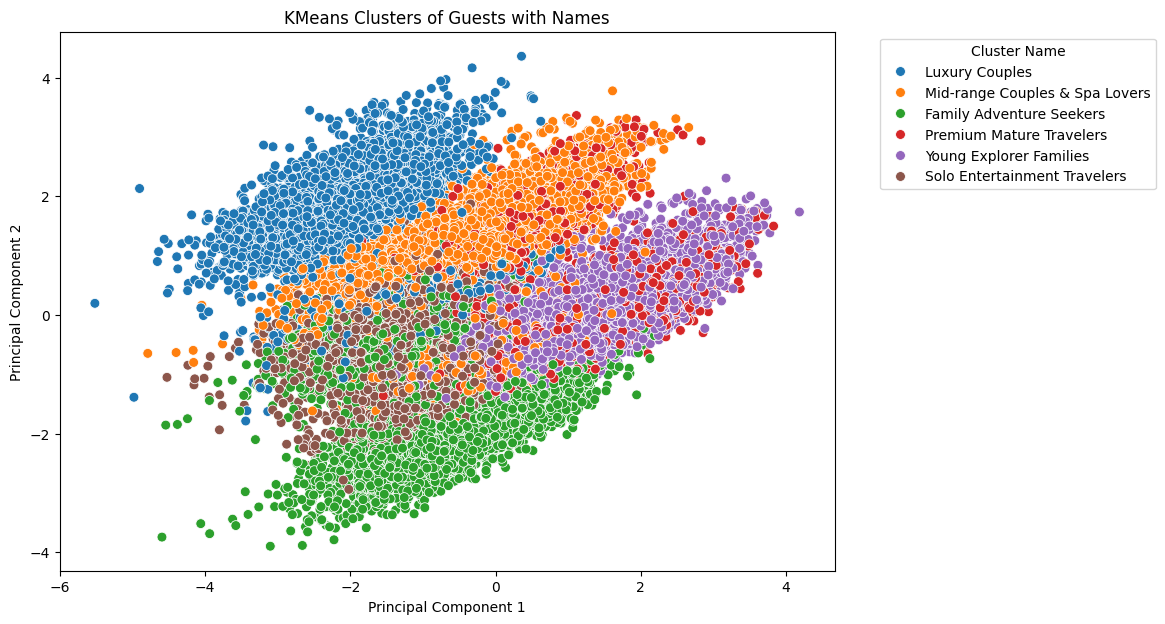

In [221]:
cluster_name_map = {
    0: 'Luxury Couples',
    1: 'Family Adventure Seekers',
    2: 'Solo Entertainment Travelers',
    3: 'Mid-range Couples & Spa Lovers',
    4: 'Young Explorer Families',
    5: 'Premium Mature Travelers'
}

plot_df['cluster_name'] = plot_df['cluster'].map(cluster_name_map)

plt.figure(figsize=(10,7))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster_name', palette='tab10', s=50)
plt.title("KMeans Clusters of Guests with Names")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


##### Luxury Couples and Premium Mature Travelers may represent high-value customers who respond well to premium or exclusive offers.
##### Family Adventure Seekers and Young Explorer Families might prefer packages with activities and group-friendly pricing.
#####  Solo Entertainment Travelers likely value experiences and convenience over luxury amenities

#### Influence by Season and Region

In [222]:
region_summary = purchases_sailings_guests.groupby(['region','category']).size().reset_index(name='num_purchases')
region_summary_pivot = region_summary.pivot(index='region', columns='category', values='num_purchases').fillna(0)
print(region_summary_pivot)


category         Activity  Dining  Entertainment  Excursion    Spa
region                                                            
Alaska              15936   28466          11526      21331  24251
Asia                23437   40516          16290      30958  35603
Australia/NZ        14189   24920          10066      18894  21614
Caribbean           56194   95695          38084      73050  83823
Mediterranean       51255   89141          35472      67604  78475
Northern Europe     29031   50972          20081      38515  45266


In [223]:
# --- Step 1: Ensure 'departure_date' is datetime ---
purchases_sailings_guests['departure_date'] = pd.to_datetime(purchases_sailings_guests['departure_date'], errors='coerce')

# --- Step 2: Derive quarter correctly ---
purchases_sailings_guests['quarter'] = purchases_sailings_guests['departure_date'].dt.quarter

# --- Step 3: Map quarter → season (apply on Series, not DataFrame) ---
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
purchases_sailings_guests['season'] = purchases_sailings_guests['quarter'].map(season_map)

# --- Step 4: Aggregate by season, region, category ---
agg = (
    purchases_sailings_guests
    .groupby(['season', 'region', 'category'])
    .size()
    .reset_index(name='num_purchases')
)

# --- Step 5: Pivot table ---
pivot_table = (
    agg.pivot_table(index=['season', 'region'],
                    columns='category',
                    values='num_purchases',
                    fill_value=0)
)

print(pivot_table)


category                Activity   Dining  Entertainment  Excursion      Spa
season region                                                               
Fall   Alaska             4401.0   7722.0         3082.0     5859.0   6541.0
       Asia               5904.0  10223.0         4085.0     7978.0   8849.0
       Australia/NZ       3511.0   6314.0         2560.0     4753.0   5519.0
       Caribbean         14872.0  24978.0         9943.0    19166.0  21745.0
       Mediterranean     14229.0  24453.0         9815.0    18554.0  21634.0
       Northern Europe    8058.0  14286.0         5655.0    10691.0  12521.0
Spring Alaska             4711.0   8403.0         3412.0     6259.0   7016.0
       Asia               6460.0  11236.0         4528.0     8560.0   9979.0
       Australia/NZ       3283.0   5914.0         2318.0     4374.0   5033.0
       Caribbean         15367.0  26329.0        10450.0    20194.0  23126.0
       Mediterranean     16382.0  28385.0        11205.0    21531.0  24856.0

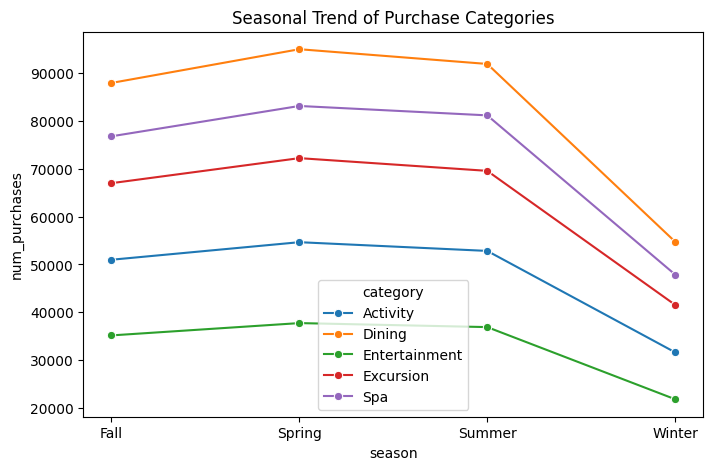

In [224]:
seasonal_trend = (
    purchases_sailings_guests
    .groupby(['season', 'category'])
    .size()
    .reset_index(name='num_purchases')
)

plt.figure(figsize=(8,5))
sns.lineplot(data=seasonal_trend, x='season', y='num_purchases', hue='category', marker='o')
plt.title("Seasonal Trend of Purchase Categories")
plt.show()


###### Inference ---Seasonal and Regional attributes has influnece on Purchases
##### Mediterranean and Caribbean itineraries consistently dominate in every season — both regions show the highest spending on Dining and Spa services, suggesting a premium customer base focused on comfort and onboard experiences.
##### 2. Excursion and Activity bookings are notably higher in Caribbean and Mediterranean cruises during Spring and Summer, reflecting the popularity of warm-weather adventure and sightseeing packages.
##### 3. Northern Europe itineraries show moderate participation across categories, with balanced interest in Dining and Entertainment but lower engagement in Spa and Excursion activities, likely due to shorter cruise durations.
##### 4. In Asia, Dining and Entertainment purchases rise during Spring and Fall, indicating that Asian routes may appeal to guests seeking cultural experiences over adventure-based excursions.
##### 5. Australia/New Zealand shows the lowest total ancillary spend across all seasons, likely due to smaller ship sizes or fewer onboard revenue opportunities.


 ### Special occasion purchase boosts

In [225]:
# Ensure bookings table has only relevant columns
bookings_small = Bookings[['booking_id','special_occasion']]

# Merge into purchases_sailings_guests
purchases_sailings_guests = purchases_sailings_guests.merge(
    bookings_small, 
    on='booking_id', 
    how='left'
)

# Fill missing occasions with 'None'
purchases_sailings_guests['special_occasion'] = purchases_sailings_guests['special_occasion'].fillna('None')


In [307]:
# Count purchases per item per special occasion
item_occasion = (
    purchases_sailings_guests
    .groupby(['special_occasion', 'item_id'])
    .size()
    .reset_index(name='num_purchases')
)

# Merge item names for readability
item_occasion = item_occasion.merge(Items[['item_id','item_name','category']], on='item_id', how='left')

# Optional: show top 5 items per special occasion
top_items_per_occasion = item_occasion.sort_values(['special_occasion','num_purchases'], ascending=[True, False]).groupby('special_occasion').head(3)

top_items_per_occasion[['special_occasion','item_name','category','num_purchases']]


,special_occasion,item_name,category,num_purchases
940,Anniversary,Exclusive Stand-up Comedy Night #01,Entertainment,152
970,Anniversary,Stand-up Comedy Show #31,Entertainment,151
948,Anniversary,Exclusive Stand-up Comedy Night #09,Entertainment,143
1984,Birthday,Acrobatic Dinner Show #45,Entertainment,178
1948,Birthday,Exclusive Stand-up Comedy Night #09,Entertainment,174
1940,Birthday,Exclusive Stand-up Comedy Night #01,Entertainment,173
2882,Graduation,Beginner's Photography #35,Activity,37
2939,Graduation,Orchestra Dinner Show #02,Entertainment,36
2951,Graduation,Premium Jazz Event #14,Entertainment,35
3985,Honeymoon,Exclusive Stand-up Comedy Night #48,Entertainment,116


### Itinery Influnence on Purchases

In [245]:
del purchases_itinerary

In [246]:
purchases_itinerary = purchases_sailings_guests.merge(
    itineries[['itinerary_id','itinerary_name']],
    on='itinerary_id',
    how='left'
)

In [228]:
purchases_itinerary = purchases_itinerary.merge(
    Items[['item_id','item_name','category']],
    on='item_id',
    how='left'
)

In [256]:

# Count number of purchases per guest-item-itinerary combination
num_purchases_df = (
    purchases_itinerary
    .groupby(['guest_id', 'item_id', 'itinerary_id'])['purchase_id']
    .count()
    .reset_index()
    .rename(columns={'purchase_id': 'num_purchases'})
)

# Merge back to main table
purchases_itinerary = purchases_itinerary.merge(
    num_purchases_df,
    on=['guest_id', 'item_id', 'itinerary_id'],
    how='left'
)

# Verify
purchases_itinerary[['guest_id', 'item_id', 'itinerary_id','num_purchases']].head()


,guest_id,item_id,itinerary_id,num_purchases
0,G000001,I0259,I085,1
1,G000001,I0231,I085,1
2,G000001,I0055,I085,1
3,G000001,I0431,I085,1
4,G000001,I0546,I085,1


In [259]:
category_by_itinerary = purchases_itinerary.groupby(['itinerary_name','category']).size().reset_index(name='num_purchases')
category_pivot = category_by_itinerary.pivot(index='itinerary_name', columns='category', values='num_purchases').fillna(0)
category_pivot.head()


category,Activity,Dining,Entertainment,Excursion,Spa
itinerary_name,,,,,
Alaska_Route_06,1437,2693,1098,1990,2319
Ancient_Shores_01,2759,4819,1923,3723,4355
Ancient_Shores_02,2908,5113,1992,3854,4531
Ancient_Shores_05,3507,6132,2484,4568,5343
Ancient_Shores_07,3444,5953,2351,4526,5200


In [260]:
item_by_itinerary = purchases_itinerary.groupby(['itinerary_name','item_name']).size().reset_index(name='num_purchases')
item_pivot = item_by_itinerary.pivot(index='itinerary_name', columns='item_name', values='num_purchases').fillna(0)


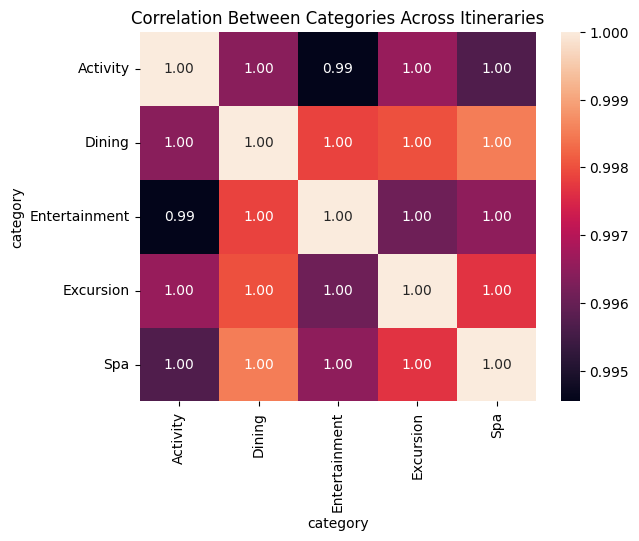

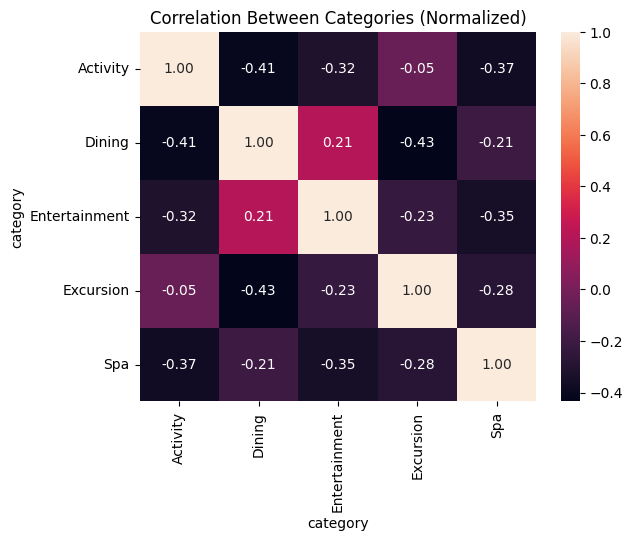

In [261]:
# Correlation between categories across itineraries
corr_matrix = category_pivot.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Between Categories Across Itineraries")
plt.show()

# Top 5 items per itinerary
top_items_per_itinerary = purchases_itinerary.groupby(['itinerary_name','item_name'])['purchase_id'].count().reset_index()
top_items_per_itinerary = top_items_per_itinerary.sort_values(['itinerary_name','purchase_id'], ascending=[True,False])
top_items_per_itinerary.groupby('itinerary_name').head(5)

category_norm = category_pivot.div(category_pivot.sum(axis=1), axis=0)
corr_matrix = category_norm.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Between Categories (Normalized)")
plt.show()



##### We observe that Dining and Entertainment show a mild positive correlation (r = 0.21), suggesting guests who enjoy premium dining experiences are also inclined to attend onboard entertainment events.
##### On the other hand, Dining and Excursion exhibit a stronger negative correlation (r = -0.43), indicating that guests who prefer off-ship adventure activities are less likely to purchase dining upgrades onboard.
##### Similarly, Activity and Spa show moderate negative correlation (r = -0.37), reflecting two different personas — one focused on adventure and engagement, and another on relaxation and wellness

### Age and Party type based Item Category Preference which is essential for Cold start Guest

Total spend by Age Group and Category:
 category      Activity      Dining  Entertainment    Excursion          Spa
age_bucket                                                                 
18-30        490905.77   950320.60      514496.88   1944679.89   1890569.68
31-45       2037634.96  4417767.54     2296099.90   9298348.57   9261506.46
46-60       2966928.26  6308969.19     3398319.57  13254712.09  13402375.18
61-85       2930192.96  7285338.92     3747075.45  14060398.01  15430139.65


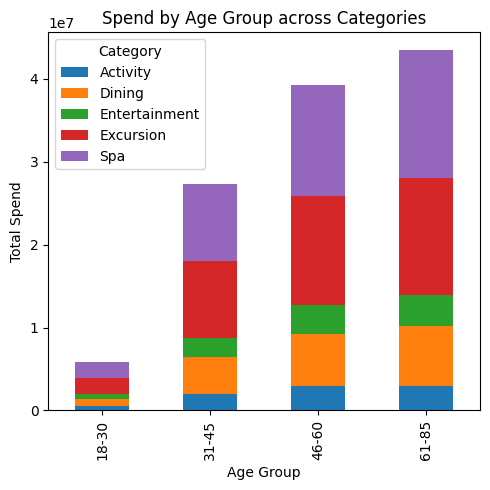


Total spend by Party Type and Category:
 category          Activity      Dining  Entertainment    Excursion  \
party_type                                                           
Couple          3811350.67  9847432.82     5169630.46  17955277.85   
Family w/ Kids  1453173.07  2999902.06     1507650.91   6670563.07   
Multi-Gen        862903.35  1880990.62     1181038.79   4715637.05   
Solo            2298234.86  4234070.75     2097671.64   9216660.59   

category                Spa  
party_type                   
Couple          20810771.36  
Family w/ Kids   6144221.64  
Multi-Gen        3858595.89  
Solo             9171002.08  


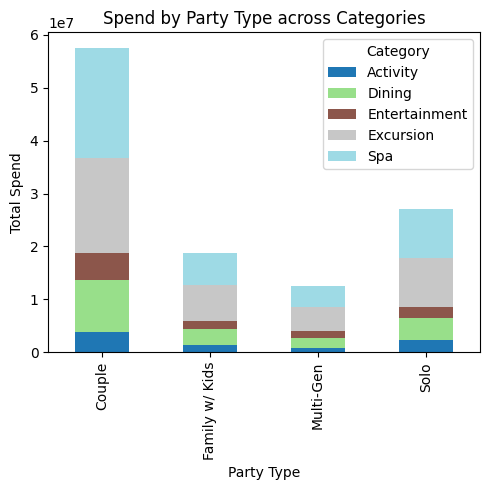

In [305]:
# 1. Create 'spend' column
purchases_sailings_guests['spend'] = purchases_sailings_guests['price']

# Optional: compute number of purchases per item/guest
purchases_sailings_guests['num_purchases'] = 1

# 2. Group by Age Group and Category
age_category = purchases_sailings_guests.groupby(['age_bucket', 'category'])['spend'].sum().unstack().fillna(0)

print("Total spend by Age Group and Category:\n", age_category)

# 3. Visualize Age vs Category Spend
age_category.plot(kind='bar', stacked=True, figsize=(5,5))
plt.title("Spend by Age Group across Categories")
plt.xlabel("Age Group")
plt.ylabel("Total Spend")
plt.legend(title='Category')
plt.tight_layout()
plt.show()

# 4. Group by Party Type and Category
party_category = purchases_sailings_guests.groupby(['party_type', 'category'])['spend'].sum().unstack().fillna(0)

print("\nTotal spend by Party Type and Category:\n", party_category)

# 5. Visualize Party Type vs Category Spend
party_category.plot(kind='bar', stacked=True, figsize=(5,5), colormap='tab20')
plt.title("Spend by Party Type across Categories")
plt.xlabel("Party Type")
plt.ylabel("Total Spend")
plt.legend(title='Category')
plt.tight_layout()
plt.show()


In [ ]:
##Duration Influence

In [101]:
# Merge purchase and sailing data
purchase_sailing2 = purchases.merge(sailings[['sailing_id', 'duration_days']], on='sailing_id', how='left')
purchase_sailing2

,purchase_id,guest_id,booking_id,sailing_id,item_id,category,item_name,price,original_price,purchase_timestamp,purchase_probability,duration_days
0,P00000001_B0000001,G000001,B0000001,CRU001237,I0259,Dining,Mexican Wine Pairing #259,72.94,80.47,2021-12-30 11:48:00,0.254780,6
1,P00000002_B0000001,G000001,B0000001,CRU001237,I0231,Dining,Asian Fusion Specialty Dinner #231,47.88,48.98,2021-12-31 13:54:00,0.326113,6
2,P00000003_B0000001,G000001,B0000001,CRU001237,I0055,Dining,Premium Japanese Experience #55,48.68,53.09,2021-12-30 01:31:00,0.316803,6
3,P00000004_B0000001,G000001,B0000001,CRU001237,I0431,Excursion,Cultural Quarter Bus Tour Adventure #151,209.71,193.90,2022-01-02 22:01:00,0.232225,6
4,P00000005_B0000001,G000001,B0000001,CRU001237,I0546,Excursion,Scenic Bike Tour Natural Park #266,116.41,120.68,2021-12-31 07:26:00,0.280995,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1190650,P00000014_B0160548,G099999,B0160548,CRU004922,I0844,Spa,Detox Treatment Ritual #164,202.70,215.27,2024-12-22 09:31:00,0.238044,9
1190651,P00000015_B0160548,G099999,B0160548,CRU004922,I0885,Activity,Beginner's Photography #35,31.17,32.43,2024-12-22 14:55:00,0.164482,9
1190652,P00000016_B0160548,G099999,B0160548,CRU004922,I0917,Activity,Beginner's Tennis #67,19.58,18.11,2024-12-23 11:22:00,0.194941,9
1190653,P00000017_B0160548,G099999,B0160548,CRU004922,I0899,Activity,Advanced Fitness Training #49,30.63,28.48,2024-12-23 20:08:00,0.172884,9


In [105]:
purchase_by_duration = (
    purchase_sailing2.groupby('duration_days')
    .agg(total_purchases=('item_id', 'count'),
         unique_guests=('guest_id', 'nunique'))
    .reset_index())

In [106]:
# Average purchases per guest
purchase_by_duration['avg_items_per_guest'] = (
    purchase_by_duration['total_purchases'] / purchase_by_duration['unique_guests']
)

print(purchase_by_duration)

   duration_days  total_purchases  unique_guests  avg_items_per_guest
0              5           134614           6551            20.548619
1              6           182163           8780            20.747494
2              7           239292          11375            21.036659
3              8           226059          10753            21.022877
4              9           225126          10767            20.908888
5             10            89017           4316            20.624884
6             11            49188           2399            20.503543
7             12            45196           2214            20.413731


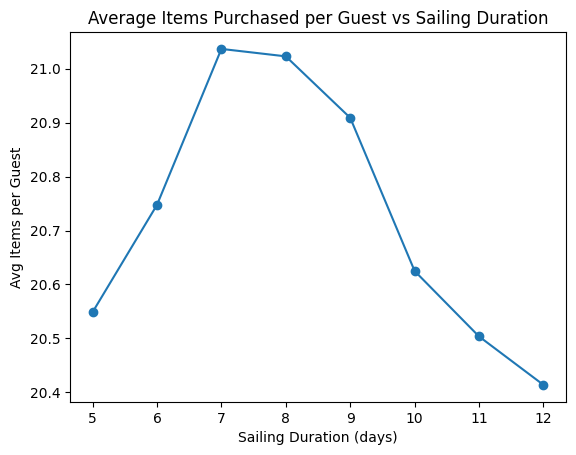

In [107]:
plt.plot(purchase_by_duration['duration_days'], purchase_by_duration['avg_items_per_guest'], marker='o')
plt.title('Average Items Purchased per Guest vs Sailing Duration')
plt.xlabel('Sailing Duration (days)')
plt.ylabel('Avg Items per Guest')
plt.show()


## Feature Engineering and  Model selection/Training

In [309]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import combinations
import ast
import warnings
warnings.filterwarnings('ignore')

class CruiseRecommendationEngine:
    def __init__(self):
        # Core datasets
        self.guests = None
        self.items = None  
        self.purchases = None
        self.sailings = None
        self.ships = None
        self.bookings = None
        self.itineraries = None
        
        # Processed features
        self.enhanced_purchases = None
        self.guest_clusters = None
        self.user_item_matrix = None
        self.item_similarity_matrix = None
        self.popularity_scores = None
        
        # Market basket insights
        self.frequent_itemsets = None
        self.association_rules = None
        self.complementary_items = None
    
    # ================================================================================
    # SECTION 1: DATA PREPROCESSING AND FEATURE ENGINEERING
    # ================================================================================
    
    def load_data(self):
        """Load all required datasets"""
        print("📊 SECTION 1: DATA PREPROCESSING AND FEATURE ENGINEERING")
        print("="*60)
        print("Loading datasets...")
        
        self.guests = pd.read_csv('guests.csv')
        self.items = pd.read_csv('items.csv')
        self.purchases = pd.read_csv('purchases_train.csv')
        self.sailings = pd.read_csv('sailings.csv')
        self.ships = pd.read_csv('ships.csv')
        self.bookings = pd.read_csv('bookings_train.csv')
        self.itineraries = pd.read_csv('itineraries.csv')
        
        print(f"✓ Loaded {len(self.guests)} guests, {len(self.items)} items, {len(self.purchases)} purchases")
        print(f"✓ Additional data: {len(self.sailings)} sailings, {len(self.ships)} ships, {len(self.bookings)} bookings")
        
    def preprocess_data(self):
        """Clean and preprocess all datasets"""
        print("\n🔧 Data Cleaning and Preprocessing...")
        
        # Handle missing values systematically
        self.guests['loyalty_tier'] = self.guests['loyalty_tier'].fillna('None')
        self.bookings['special_occasion'] = self.bookings['special_occasion'].fillna('None')
        self.items['port_of_call'] = self.items['port_of_call'].fillna('None')
        self.items['min_age'] = self.items['min_age'].fillna(0)
        
        # Parse ship types from string representation to list
        def parse_ship_types(ship_types_str):
            if pd.isna(ship_types_str):
                return ['All']
            try:
                return ast.literal_eval(ship_types_str)
            except:
                return ['All']
        
        self.items['available_on_ship_types'] = self.items['available_on_ship_types'].apply(parse_ship_types)
        
        print("✓ Missing values handled")
        
    def engineer_features(self):
        """Create derived features for enhanced modeling"""
        print("\n⚙️ Feature Engineering...")
        
        # Revenue potential scoring for items
        price_percentile = self.items['price'].quantile(0.75)
        self.items['revenue_potential'] = (
            (self.items['price'] / price_percentile) * 0.5 + 
            self.items['high_margin'].astype(int) * 0.5
        )
        
        # Guest age segmentation
        self.guests['age_bucket'] = pd.cut(
            self.guests['age'], 
            bins=[0, 30, 45, 60, 120], 
            labels=['18-30', '31-45', '46-60', '60+']
        )
        
        # Seasonal features for sailings
        self.sailings['departure_date'] = pd.to_datetime(self.sailings['departure_date'])
        self.sailings['season'] = self.sailings['departure_date'].dt.quarter.map({
            1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'
        })
        
        # Guest spending patterns
        guest_spending = self.purchases.groupby('guest_id').agg({
            'price': ['sum', 'mean', 'count'],
            'item_id': 'nunique'
        }).round(2)
        guest_spending.columns = ['total_spend', 'avg_spend', 'purchase_count', 'unique_items']
        guest_spending = guest_spending.reset_index()
        
        # Merge spending patterns back to guests
        self.guests = self.guests.merge(guest_spending, on='guest_id', how='left')
        self.guests[['total_spend', 'avg_spend', 'purchase_count', 'unique_items']] = \
            self.guests[['total_spend', 'avg_spend', 'purchase_count', 'unique_items']].fillna(0)
        
        print("✓ Revenue potential scores created")
        print("✓ Age buckets and seasonal features added")
        print("✓ Guest spending patterns calculated")
        
    def create_enhanced_purchases(self):
        """Create comprehensive purchase dataset with all engineered features"""
        print("\n🔗 Creating Enhanced Purchase Dataset...")
        
        # Start with core purchase data
        enhanced = self.purchases[['guest_id', 'sailing_id', 'item_id', 'purchase_id']].copy()
        
        # Add guest information and features
        guest_cols = ['guest_id', 'age', 'party_type', 'loyalty_tier', 'age_bucket', 
                     'total_spend', 'avg_spend', 'purchase_count', 'unique_items']
        enhanced = enhanced.merge(self.guests[guest_cols], on='guest_id', how='left')
        
        # Add sailing and seasonal context
        sailing_cols = ['sailing_id', 'ship_id', 'itinerary_id', 'region', 'season', 'departure_date']
        enhanced = enhanced.merge(self.sailings[sailing_cols], on='sailing_id', how='left')
        
        # Add ship characteristics
        enhanced = enhanced.merge(self.ships[['ship_id', 'ship_type']], on='ship_id', how='left')
        
        # Add item characteristics
        item_cols = ['item_id', 'category', 'price', 'high_margin', 'revenue_potential', 
                    'available_on_ship_types', 'min_age']
        enhanced = enhanced.merge(self.items[item_cols], on='item_id', how='left')
        
        # Add special occasion information
        booking_occasions = self.bookings[['guest_id', 'sailing_id', 'special_occasion']].drop_duplicates()
        enhanced = enhanced.merge(booking_occasions, on=['guest_id', 'sailing_id'], how='left')
        enhanced['special_occasion'] = enhanced['special_occasion'].fillna('None')
        
        self.enhanced_purchases = enhanced
        print(f"✓ Enhanced purchases dataset created: {enhanced.shape}")
        print(f"✓ Features included: {len(enhanced.columns)} columns")
        
    def analyze_market_basket(self):
        """Perform optimized market basket analysis to find complementary items"""
        print("\n🛒 Market Basket Analysis for Complementary Items...")
        
        # Create transaction-based dataset (guest-sailing combinations)
        transactions = self.enhanced_purchases.groupby(['guest_id', 'sailing_id'])['item_id'].apply(list).reset_index()
        
        # Optimize: Sample transactions if dataset is large
        max_transactions = 50000  # Process max 50k transactions for efficiency
        if len(transactions) > max_transactions:
            print(f"   Sampling {max_transactions} transactions from {len(transactions)} for efficiency...")
            transactions = transactions.sample(n=max_transactions, random_state=42)
        
        transactions['transaction_id'] = transactions.index
        
        # Find frequent item pairs using optimized approach
        item_pairs = {}
        complementary_items = {}
        
        # Process transactions with progress tracking
        processed = 0
        for idx, row in transactions.iterrows():
            items_in_transaction = list(row['item_id'])  # Ensure it's a list
            if len(items_in_transaction) > 1:
                # Limit pairs per transaction to avoid explosion
                items_limited = items_in_transaction[:10]  # Max 10 items per transaction
                # Generate all pairs in this transaction
                for item1, item2 in combinations(items_limited, 2):
                    # Ensure items are comparable types (keep as strings)
                    pair = tuple(sorted([str(item1), str(item2)]))
                    item_pairs[pair] = item_pairs.get(pair, 0) + 1
            
            processed += 1
            if processed % 10000 == 0:
                print(f"   Processed {processed}/{len(transactions)} transactions...")
        
        # Filter pairs with minimum support (appearing in at least 3 transactions for efficiency)
        min_support = 3
        frequent_pairs = {pair: count for pair, count in item_pairs.items() if count >= min_support}
        
        # Pre-calculate item counts for efficiency
        item_counts = self.purchases['item_id'].value_counts().to_dict()
        
        # Create complementary items mapping
        for (item1, item2), count in frequent_pairs.items():
            # Calculate confidence: P(item2|item1)
            item1_count = item_counts.get(item1, 0)
            item2_count = item_counts.get(item2, 0)
            
            confidence_1_to_2 = count / item1_count if item1_count > 0 else 0
            confidence_2_to_1 = count / item2_count if item2_count > 0 else 0
            
            # Only store if confidence is meaningful (> 0.01)
            if confidence_1_to_2 > 0.01:
                if item1 not in complementary_items:
                    complementary_items[item1] = []
                complementary_items[item1].append({
                    'item_id': item2, 
                    'confidence': confidence_1_to_2, 
                    'support': count
                })
            
            if confidence_2_to_1 > 0.01:
                if item2 not in complementary_items:
                    complementary_items[item2] = []
                complementary_items[item2].append({
                    'item_id': item1, 
                    'confidence': confidence_2_to_1, 
                    'support': count
                })
        
        # Sort complementary items by confidence
        for item_id in complementary_items:
            complementary_items[item_id] = sorted(
                complementary_items[item_id], 
                key=lambda x: x['confidence'], 
                reverse=True
            )[:5]  # Keep top 5 complementary items
        
        self.complementary_items = complementary_items
        print(f"✓ Found {len(frequent_pairs)} frequent item pairs")
        print(f"✓ Generated complementary item mappings for {len(complementary_items)} items")
        
    # ================================================================================
    # SECTION 2: MODEL TRAINING AND RECOMMENDATION LOGIC
    # ================================================================================
    
    def train_models(self):
        """Train all recommendation models"""
        print("\n🤖 SECTION 2: MODEL TRAINING AND RECOMMENDATION LOGIC")
        print("="*60)
        
        self.train_customer_segments()
        self.add_cluster_info_to_purchases()
        self.build_user_item_matrix()
        self.calculate_item_similarities()
        self.build_popularity_scores()
        
    def train_customer_segments(self, n_clusters=6):
        """Train customer segmentation using K-means clustering"""
        print("🎯 Training Customer Segmentation Model...")
        
        # Create category preference features
        category_features = self.purchases.pivot_table(
            index='guest_id', columns='category', values='purchase_id',
            aggfunc='count', fill_value=0
        )
        category_proportions = category_features.div(category_features.sum(axis=1), axis=0).fillna(0)
        
        # Create spending pattern features
        avg_spend = self.purchases.pivot_table(
            index='guest_id', columns='category', values='price',
            aggfunc='mean', fill_value=0
        )
        
        # Get demographic features for guests with purchases
        guest_ids_with_purchases = category_features.index
        guest_demos = self.guests[self.guests['guest_id'].isin(guest_ids_with_purchases)].copy()
        guest_demos = guest_demos.set_index('guest_id')
        
        # Find common guests across all feature sets
        common_guests = list(set(category_features.index) & 
                           set(avg_spend.index) & 
                           set(guest_demos.index))
        
        # Filter to common guests
        category_features_filtered = category_features.loc[common_guests]
        avg_spend_filtered = avg_spend.loc[common_guests]
        guest_demos_filtered = guest_demos.loc[common_guests]
        
        # Encode demographic features
        demographics_encoded = pd.get_dummies(
            guest_demos_filtered[['party_type', 'loyalty_tier', 'age_bucket']]
        )
        
        # Combine all features
        guest_features = pd.concat([
            category_features_filtered, 
            avg_spend_filtered, 
            demographics_encoded
        ], axis=1).fillna(0)
        
        # Scale features for clustering
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(guest_features)
        
        # Train K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Create cluster mapping
        self.guest_clusters = pd.DataFrame({
            'guest_id': guest_features.index,
            'cluster': cluster_labels
        })
        
        # Display cluster insights
        cluster_counts = np.bincount(cluster_labels)
        print(f"✓ Customer segmentation completed with {n_clusters} clusters")
        print(f"✓ Cluster distribution: {dict(enumerate(cluster_counts))}")
        
        # Analyze cluster characteristics
        cluster_analysis = self.enhanced_purchases.merge(self.guest_clusters, on='guest_id', how='inner')
        cluster_summary = cluster_analysis.groupby('cluster').agg({
            'price': 'mean',
            'category': lambda x: x.mode()[0] if not x.empty else 'Unknown',
            'loyalty_tier': lambda x: x.mode()[0] if not x.empty else 'None'
        }).round(2)
        
        print("✓ Cluster Characteristics:")
        for cluster_id, row in cluster_summary.iterrows():
            print(f"   Cluster {cluster_id}: Avg Spend ${row['price']}, "
                  f"Top Category: {row['category']}, Top Loyalty: {row['loyalty_tier']}")
    
    def add_cluster_info_to_purchases(self):
        """Add cluster information to enhanced purchases dataset"""
        print("\n🔗 Adding Cluster Information to Purchase Data...")
        
        self.enhanced_purchases = self.enhanced_purchases.merge(
            self.guest_clusters, on='guest_id', how='left'
        )
        self.enhanced_purchases['cluster'] = self.enhanced_purchases['cluster'].fillna(0)
        print("✓ Cluster information merged to enhanced purchases")
        
    def build_user_item_matrix(self):
        """Build user-item interaction matrix for collaborative filtering"""
        print("\n📊 Building User-Item Interaction Matrix...")
        
        # Create binary interaction matrix
        self.user_item_matrix = self.purchases.pivot_table(
            index='guest_id', columns='item_id', values='purchase_id',
            aggfunc='count', fill_value=0
        )
        
        # Convert to binary (1 if purchased, 0 otherwise)
        self.user_item_matrix = (self.user_item_matrix > 0).astype(int)
        
        sparsity = (1 - self.user_item_matrix.values.sum() / self.user_item_matrix.size) * 100
        print(f"✓ User-item matrix created: {self.user_item_matrix.shape}")
        print(f"✓ Matrix sparsity: {sparsity:.2f}%")
        
    def calculate_item_similarities(self):
        """Calculate item-item similarity matrix using cosine similarity"""
        print("\n🔍 Calculating Item-Item Similarities...")
        
        # Calculate cosine similarity between items
        item_similarities = cosine_similarity(self.user_item_matrix.T)
        
        self.item_similarity_matrix = pd.DataFrame(
            item_similarities,
            index=self.user_item_matrix.columns,
            columns=self.user_item_matrix.columns
        )
        
        print(f"✓ Item similarity matrix calculated: {self.item_similarity_matrix.shape}")
        
    def build_popularity_scores(self):
        """Build context-aware popularity scores"""
        print("\n📈 Building Context-Aware Popularity Scores...")
        
        # Overall item popularity
        overall_pop = self.purchases.groupby('item_id').size().reset_index(name='overall_popularity')
        
        # Context-aware popularity by cluster, season, and region
        context_pop = self.enhanced_purchases.groupby([
            'cluster', 'season', 'region', 'item_id'
        ]).size().reset_index(name='context_popularity')
        
        # Category-wise popularity
        category_pop = self.purchases.groupby(['category', 'item_id']).size().reset_index(name='category_popularity')
        
        # Merge with item information
        self.popularity_scores = overall_pop.merge(
            self.items[['item_id', 'category', 'price', 'high_margin', 'revenue_potential']], 
            on='item_id', how='left'
        )
        
        print("✓ Popularity scores calculated with contextual factors")
        
    def get_eligible_items(self, sailing_id, guest_age):
        """Filter items eligible for specific sailing and guest age"""
        sailing_info = self.sailings[self.sailings['sailing_id'] == sailing_id].iloc[0]
        ship_info = self.ships[self.ships['ship_id'] == sailing_info['ship_id']].iloc[0]
        
        eligible_items = []
        for idx, item in self.items.iterrows():
            ship_types = item['available_on_ship_types']
            
            # Check ship type eligibility
            try:
                if isinstance(ship_types, list):
                    ship_eligible = 'All' in ship_types or ship_info['ship_type'] in ship_types
                elif pd.isna(ship_types):
                    ship_eligible = True
                else:
                    # Parse string representation
                    ship_types_list = ast.literal_eval(str(ship_types))
                    ship_eligible = 'All' in ship_types_list or ship_info['ship_type'] in ship_types_list
            except:
                ship_eligible = True  # Default to eligible if parsing fails
            
            # Check age requirement
            if ship_eligible and item['min_age'] <= guest_age:
                eligible_items.append(item['item_id'])
        
        return eligible_items
    
    def recommend_cold_start(self, guest_id, sailing_id, top_k=10):
        """Generate recommendations for guests with no purchase history"""
        guest_info = self.guests[self.guests['guest_id'] == guest_id].iloc[0]
        sailing_info = self.sailings[self.sailings['sailing_id'] == sailing_id].iloc[0]
        
        # Get eligible items
        eligible_items = self.get_eligible_items(sailing_id, guest_info['age'])
        
        # Find demographically similar guests
        similar_guests = self.guests[
            (self.guests['age_bucket'] == guest_info['age_bucket']) &
            (self.guests['party_type'] == guest_info['party_type']) &
            (self.guests['loyalty_tier'] == guest_info['loyalty_tier'])
        ]['guest_id'].tolist()
        
        # Get popular items among similar guests
        similar_purchases = self.enhanced_purchases[
            self.enhanced_purchases['guest_id'].isin(similar_guests)
        ]
        
        # Score items based on popularity and guest characteristics
        item_scores = similar_purchases.groupby('item_id').agg({
            'purchase_id': 'count',
            'price': 'mean'
        }).reset_index()
        
        # Apply loyalty tier boost for high-margin items
        if guest_info['loyalty_tier'] in ['Gold', 'Platinum']:
            item_scores = item_scores.merge(self.items[['item_id', 'high_margin']], on='item_id')
            item_scores['score'] = item_scores['purchase_id'] + item_scores['high_margin'] * 2
        else:
            item_scores['score'] = item_scores['purchase_id']
        
        # Filter to eligible items and return top recommendations
        recommendations = item_scores[
            item_scores['item_id'].isin(eligible_items)
        ].sort_values('score', ascending=False).head(top_k)
        
        return recommendations['item_id'].tolist()
    
    def recommend_collaborative(self, guest_id, sailing_id, top_k=10):
        """Generate collaborative filtering recommendations"""
        if guest_id not in self.user_item_matrix.index:
            return self.recommend_cold_start(guest_id, sailing_id, top_k)
        
        guest_info = self.guests[self.guests['guest_id'] == guest_id].iloc[0]
        eligible_items = self.get_eligible_items(sailing_id, guest_info['age'])
        
        # Get guest's purchase history
        guest_purchases = self.user_item_matrix.loc[guest_id]
        purchased_items = guest_purchases[guest_purchases > 0].index.tolist()
        
        # Calculate item-based collaborative filtering scores
        recommendations = {}
        for item_id in eligible_items:
            if item_id in purchased_items:
                continue  # Skip already purchased items
                
            score = 0
            for purchased_item in purchased_items:
                if (purchased_item in self.item_similarity_matrix.index and 
                    item_id in self.item_similarity_matrix.columns):
                    score += self.item_similarity_matrix.loc[purchased_item, item_id]
            
            recommendations[item_id] = score
        
        # Sort and return top recommendations
        top_items = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return [item[0] for item in top_items]
    
    def get_complementary_recommendations(self, purchased_items, eligible_items, top_k=5):
        """Get complementary item recommendations based on market basket analysis"""
        complementary_recs = {}
        
        for item_id in purchased_items:
            if item_id in self.complementary_items:
                for comp_item in self.complementary_items[item_id]:
                    comp_item_id = comp_item['item_id']
                    if comp_item_id in eligible_items and comp_item_id not in purchased_items:
                        confidence = comp_item['confidence']
                        support = comp_item['support']
                        
                        # Weighted score combining confidence and support
                        score = confidence * 0.7 + (support / 100) * 0.3
                        
                        if comp_item_id in complementary_recs:
                            complementary_recs[comp_item_id] = max(complementary_recs[comp_item_id], score)
                        else:
                            complementary_recs[comp_item_id] = score
        
        # Sort and return top complementary items
        top_complementary = sorted(complementary_recs.items(), key=lambda x: x[1], reverse=True)[:top_k]
        return [item[0] for item in top_complementary]
    
    def recommend(self, guest_id, sailing_id, top_k=10):
        """Main recommendation function with integrated market basket insights"""
        guest_purchase_count = len(self.purchases[self.purchases['guest_id'] == guest_id])
        
        if guest_purchase_count == 0:
            # Cold start recommendations
            return self.recommend_cold_start(guest_id, sailing_id, top_k)
        
        elif guest_purchase_count < 5:
            # Sparse history - blend multiple approaches
            cold_recs = self.recommend_cold_start(guest_id, sailing_id, top_k//2)
            collab_recs = self.recommend_collaborative(guest_id, sailing_id, top_k//2)
            
            # Combine and deduplicate
            combined_recs = cold_recs + [item for item in collab_recs if item not in cold_recs]
            return combined_recs[:top_k]
        
        else:
            # Rich history - use collaborative filtering + complementary items
            collab_recs = self.recommend_collaborative(guest_id, sailing_id, top_k-3)
            
            # Get purchased items for complementary analysis
            guest_purchases = self.user_item_matrix.loc[guest_id]
            purchased_items = guest_purchases[guest_purchases > 0].index.tolist()
            
            # Get eligible items for this sailing
            guest_info = self.guests[self.guests['guest_id'] == guest_id].iloc[0]
            eligible_items = self.get_eligible_items(sailing_id, guest_info['age'])
            
            # Add complementary items
            complementary_recs = self.get_complementary_recommendations(
                purchased_items, eligible_items, top_k=3
            )
            
            # Combine collaborative and complementary recommendations
            final_recs = collab_recs + [item for item in complementary_recs if item not in collab_recs]
            return final_recs[:top_k]
    
    # ================================================================================
    # SECTION 3: SUBMISSION FILE GENERATION
    # ================================================================================
    
    def generate_submission(self, output_file='submission.csv'):
        """Generate competition submission file"""
        print("\n📝 SECTION 3: SUBMISSION FILE GENERATION")
        print("="*60)
        print("🎯 Generating submission for test queries...")
        
        # Load test queries
        queries = pd.read_csv('queries_test.csv')
        print(f"   Loaded {len(queries)} test queries")
        
        results = []
        successful_recommendations = 0
        failed_recommendations = 0
        
        for idx, query in queries.iterrows():
            guest_id = query['guest_id']
            sailing_id = query['sailing_id']
            
            try:
                # Get recommendations using main recommendation engine
                recommendations = self.recommend(guest_id, sailing_id, top_k=10)
                
                # Ensure we have exactly 10 recommendations
                if len(recommendations) < 10:
                    # Pad with popular items not already recommended
                    popular_items = self.popularity_scores.sort_values(
                        'overall_popularity', ascending=False
                    )
                    for _, item_row in popular_items.iterrows():
                        if len(recommendations) >= 10:
                            break
                        if item_row['item_id'] not in recommendations:
                            recommendations.append(item_row['item_id'])
                
                # Create submission rows
                for rank, item_id in enumerate(recommendations[:10], 1):
                    results.append({
                        'guest_id': guest_id,
                        'sailing_id': sailing_id,
                        'rank': rank,
                        'item_id': item_id
                    })
                
                successful_recommendations += 1
                    
            except Exception as e:
                print(f"   Warning: Failed recommendations for {guest_id}, {sailing_id}: {e}")
                failed_recommendations += 1
                
                # Fallback to most popular items
                popular_items = self.popularity_scores.sort_values(
                    'overall_popularity', ascending=False
                ).head(10)
                
                for rank, (_, item_row) in enumerate(popular_items.iterrows(), 1):
                    results.append({
                        'guest_id': guest_id,
                        'sailing_id': sailing_id,
                        'rank': rank,
                        'item_id': item_row['item_id']
                    })
            
            # Progress update
            if (idx + 1) % 100 == 0:
                print(f"   Processed {idx+1}/{len(queries)} queries")
        
        # Create submission DataFrame
        submission_df = pd.DataFrame(results)
        submission_df.to_csv(output_file, index=False)
        
        # Validation and summary
        print(f"\n✅ Submission Generation Complete!")
        print(f"   File saved: {output_file}")
        print(f"   Total recommendations: {len(submission_df)}")
        print(f"   Expected: {len(queries) * 10}")
        print(f"   Successful queries: {successful_recommendations}")
        print(f"   Failed queries: {failed_recommendations}")
        
        # Validate submission format
        expected_columns = ['guest_id', 'sailing_id', 'rank', 'item_id']
        if list(submission_df.columns) == expected_columns:
            print("✅ Submission format is correct!")
        else:
            print(f"❌ Format issue! Expected: {expected_columns}, Got: {list(submission_df.columns)}")
        
        # Show sample recommendations
        print("\n📋 Sample Submission:")
        print(submission_df.head(15))
        
        # Recommendation diversity analysis
        unique_items_recommended = submission_df['item_id'].nunique()
        total_items_available = len(self.items)
        diversity_score = (unique_items_recommended / total_items_available) * 100
        
        print(f"\n📊 Recommendation Analysis:")
        print(f"   Unique items recommended: {unique_items_recommended}")
        print(f"   Total items available: {total_items_available}")
        print(f"   Diversity score: {diversity_score:.2f}%")
        
        return submission_df
    
    # ================================================================================
    # MAIN PIPELINE AND UTILITY METHODS
    # ================================================================================
    
    def fit(self):
        """Complete training pipeline"""
        print("🚀 TRAINING CRUISE RECOMMENDATION ENGINE")
        print("="*80)
        
        # Section 1: Data preprocessing and feature engineering
        self.preprocess_data()
        self.engineer_features()
        self.create_enhanced_purchases()
        self.analyze_market_basket()
        
        # Section 2: Model training and recommendation logic
        self.train_models()
        
        print("\n✅ TRAINING COMPLETED SUCCESSFULLY!")
        print("="*80)
        
    def train_full_pipeline(self):
        """Load data and train complete pipeline"""
        self.load_data()
        self.fit()
        
    def evaluate_on_sample(self, n_samples=5):
        """Test recommendations on sample guests"""
        print(f"\n🧪 Testing recommendations on {n_samples} sample guests...")
        
        sample_purchases = self.enhanced_purchases.sample(n_samples)
        
        for idx, row in sample_purchases.iterrows():
            guest_id = row['guest_id']
            sailing_id = row['sailing_id']
            
            recommendations = self.recommend(guest_id, sailing_id, top_k=5)
            
            print(f"\nGuest {guest_id} (Sailing {sailing_id}):")
            print(f"   Recommendations: {recommendations}")
            
            # Show complementary items if available
            if guest_id in self.user_item_matrix.index:
                guest_purchases = self.user_item_matrix.loc[guest_id]
                purchased_items = guest_purchases[guest_purchases > 0].index.tolist()[:3]
                
                if purchased_items:
                    print(f"   Recent purchases: {purchased_items}")
                    
                    eligible_items = self.get_eligible_items(sailing_id, row['age'])
                    complementary = self.get_complementary_recommendations(
                        purchased_items, eligible_items, top_k=3
                    )
                    if complementary:
                        print(f"   Complementary items: {complementary}")
            
        print("✅ Sample testing completed!")
    
    def quick_test(self):
        """Quick validation test"""
        print("🧪 Running Quick Validation Test...")
        
        try:
            # Test data loading
            self.load_data()
            print("✅ Data loading successful")
            
            # Test preprocessing
            self.preprocess_data()
            self.engineer_features()
            print("✅ Data preprocessing successful")
            
            # Test enhanced purchases creation
            self.create_enhanced_purchases()
            print("✅ Enhanced purchases creation successful")
            
            # Test basic recommendation
            sample_guest = self.guests.iloc[0]['guest_id']
            sample_sailing = self.purchases.iloc[0]['sailing_id']
            
            # Create minimal popularity scores for testing
            popular_items = self.purchases.groupby('item_id').size().reset_index(name='overall_popularity')
            self.popularity_scores = popular_items.merge(
                self.items[['item_id', 'category', 'price', 'high_margin']], on='item_id'
            )
            
            print("🎉 Quick test passed! All components working correctly.")
            return True
            
        except Exception as e:
            print(f"❌ Quick test failed: {e}")
            import traceback
            traceback.print_exc()
            return False

# Usage example and main execution
if __name__ == "__main__":
    engine = CruiseRecommendationEngine()
    
    # Run quick test first
    if engine.quick_test():
        print("\n" + "="*80)
        print("RUNNING FULL PIPELINE...")
        print("="*80)
        
        # Train complete system
        engine.train_full_pipeline()
        
        # Evaluate on sample
        engine.evaluate_on_sample()
        
        # Generate final submission
        submission_df = engine.generate_submission()
        
        print("\n🎉 PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
        
    else:
        print("❌ Quick test failed. Please debug before running full pipeline.")

🧪 Running Quick Validation Test...
📊 SECTION 1: DATA PREPROCESSING AND FEATURE ENGINEERING
Loading datasets...
✓ Loaded 100000 guests, 1000 items, 1190655 purchases
✓ Additional data: 6195 sailings, 40 ships, 109991 bookings
✅ Data loading successful

🔧 Data Cleaning and Preprocessing...
✓ Missing values handled

⚙️ Feature Engineering...
✓ Revenue potential scores created
✓ Age buckets and seasonal features added
✓ Guest spending patterns calculated
✅ Data preprocessing successful

🔗 Creating Enhanced Purchase Dataset...
✓ Enhanced purchases dataset created: (1190655, 25)
✓ Features included: 25 columns
✅ Enhanced purchases creation successful
🎉 Quick test passed! All components working correctly.

RUNNING FULL PIPELINE...
📊 SECTION 1: DATA PREPROCESSING AND FEATURE ENGINEERING
Loading datasets...
✓ Loaded 100000 guests, 1000 items, 1190655 purchases
✓ Additional data: 6195 sailings, 40 ships, 109991 bookings
🚀 TRAINING CRUISE RECOMMENDATION ENGINE

🔧 Data Cleaning and Preprocessing..